### train_label中的01二分类的分布

In [23]:
shutil.rmtree('base_dir')

In [24]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
from keras import optimizers


data = pd.read_csv('/kaggle/input/train_labels.csv')
train_path = '/kaggle/input/train/'
test_path = '/kaggle/input/test/'
# quick look at the label stats
data['label'].value_counts()

data = data.sample(10000, random_state = 101)
data['label'].value_counts()


data.head()

def readImage(path):
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

shuffled_data = shuffle(data)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('picture',fontsize=20)
# 无肿瘤
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # 框出中心32*32
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('NONE tumor sample', size='large')
# 有肿瘤
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('tumor sample', size='large')





import random
ORIGINAL_SIZE = 96      # original size of the images - do not change

# AUGMENTATION VARIABLES
CROP_SIZE = 90          # final size after crop
RANDOM_ROTATION = 3    # range (0-180), 180 allows all rotation variations, 0=no change
RANDOM_SHIFT = 2        # center crop shift in x and y axes, 0=no change. This cannot be more than (ORIGINAL_SIZE - CROP_SIZE)//2 
RANDOM_BRIGHTNESS = 7  # range (0-100), 0=no change
RANDOM_CONTRAST = 5    # range (0-100), 0=no change
RANDOM_90_DEG_TURN = 1  # 0 or 1= random turn to left or right

def readCroppedImage(path, augmentations = True):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations):
        return rgb_img / 255
    
    #random rotation
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1):
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48),rotation,1)   # the center point is the rotation anchor
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    # Random flip
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor):
        rgb_img = rgb_img[:, ::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1, :]
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    # clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    
    return rgb_img





fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Cropped histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif'))
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif'))
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')



fig, ax = plt.subplots(1,5, figsize=(20,4))
fig.suptitle('Random augmentations to the same image',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:1]):
    for j in range(5):
        path = os.path.join(train_path, idx)
        ax[j].imshow(readCroppedImage(path + '.tif'))




# As we count the statistics, we can check if there are any completely black or white images
dark_th = 10 / 255      # If no pixel reaches this threshold, image is considered too dark
bright_th = 245 / 255   # If no pixel is under this threshold, image is considerd too bright
too_dark_idx = []
too_bright_idx = []

x_tot = np.zeros(3)
x2_tot = np.zeros(3)
counted_ones = 0
for i, idx in tqdm_notebook(enumerate(shuffled_data['id']), 'computing statistics...(10000 it total)'):
    path = os.path.join(train_path, idx)
    imagearray = readCroppedImage(path + '.tif', augmentations = False).reshape(-1,3)
#     imagearray = readImage(path + '.tif')
    # is this too dark
    if(imagearray.max() < dark_th):
        too_dark_idx.append(idx)
        continue # do not include in statistics
    # is this too bright
    if(imagearray.min() > bright_th):
        too_bright_idx.append(idx)
        continue # do not include in statistics
    x_tot += imagearray.mean(axis=0)
    x2_tot += (imagearray**2).mean(axis=0)
    counted_ones += 1
    
channel_avr = x_tot/counted_ones
channel_std = np.sqrt(x2_tot/counted_ones - channel_avr**2)
print(channel_avr,channel_std)


print('There was {0} extremely dark image'.format(len(too_dark_idx)))
print('and {0} extremely bright images'.format(len(too_bright_idx)))
print('Dark one:')
print(too_dark_idx)
print('Bright ones:')
print(too_bright_idx)


from sklearn.model_selection import train_test_split
train_df = data

#If removing outliers, uncomment the four lines below
print('Before removing outliers we had {0} training samples.'.format(len(train_df)))
# train_df[(~train_df['id'].isin(too_dark_idx))]
# train_df = train_df.drop(labels=too_dark_idx, axis=0)
# train_df = train_df.drop(labels=too_bright_idx, axis=0)
# train_df = train_df[train_df.id != too_dark_idx]
for i in too_dark_idx:
    train_df =  train_df[train_df['id'] != i]
    
for j in too_bright_idx:
    train_df =  train_df[train_df['id'] != j]

print('After removing outliers we have {0} training samples.'.format(len(train_df)))

train_names = train_df.id.values
train_labels = np.asarray(train_df['label'].values)

# split, this function returns more than we need as we only need the validation indexes for fastai
df_train, df_val= train_test_split(train_df, test_size=0.1, stratify=train_labels, random_state=123)


df_train.shape






df_train['label'].value_counts()
df_val['label'].value_counts()
print(os.listdir('../'))
import shutil
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue

# val_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue
    
# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


os.listdir("../working/base_dir")


os.listdir('base_dir/train_dir')


train_df.head()








# Set the id as the index in df_data
df_data = train_df
df_data.set_index('id', inplace=True)
import shutil
os.listdir("/kaggle")
df_train.head()

plt.imshow((readImage('/kaggle/input/train/6633b7c7caf328f4a3bd54a5b70f1ddd724cf8d0' + '.tif')))




train_list = list(df_train['id'])
val_list = list(df_val['id'])

train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
#     infnamepath = '../input/train/'+fname
#     imagearray = readCroppedImage(infnamepath)
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('../input/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
#     outfnamepath = train_dir+'/'+label+'/'+fname
#     r,g,b = cv2.split((imagearray * 255).astype(int)) 
#     bgr_img = cv2.merge([b,g,r])
#     cv2.imwrite(outfnamepath, bgr_img)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
#     infnamepath = '/kaggle/input/train/'+fname
#     imagearray = readCroppedImage(infnamepath)
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('/kaggle/input/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
#     outfnamepath = val_dir+'/'+label+'/'+fname
#     r,g,b = cv2.split((imagearray * 255).astype(int)) 
#     bgr_img = cv2.merge([b,g,r])
#     cv2.imwrite(outfnamepath, bgr_img)











# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_tumor_tissue')))


# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/val_dir/b_has_tumor_tissue')))



train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SIZE = 96



datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)



from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline



[0.70254783 0.54833091 0.69720554] [0.23974731 0.28303609 0.21687608]
There was 0 extremely dark image
and 0 extremely bright images
Dark one:
[]
Bright ones:
[]
Before removing outliers we had 10000 training samples.
After removing outliers we have 10000 training samples.
['input', 'config', 'working', 'lib']
5416
3584
602
398
Found 9000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 读取图片

In [25]:
kernel_size = (3,3)
pool_size= (2,2)
pool_size1 = (1,1)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size1))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 41, 41, 64)        36928     
__________

In [ ]:
import numpy as np
#if os.access("model.h5", os.F_OK):
# os.remove("model.h5")
#os.listdir('./')

a = np.linspace( 0.01, 0.00005, 6 ) 

for num in range(0,6):  # 迭代 10 到 20 之间的数字
    lr=a[num]
    print('lr**********',lr)
    print(num)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

if os.access("model.h5", os.F_OK):
    os.remove("model.h5")
os.listdir('./')

rate = np.linspace( 0.01, 0.00005, 3 ) 
#accu_array=np.linspace( 0, 0, 6 ) 

for num in range(1,3):  # 迭代 10 到 20 之间的数字
    learning_rate=rate[num]
    print('learning_rate**********',learning_rate)
    #sgd = optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
    #Adam=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    model.compile(Adam(lr=0.01), loss='binary_crossentropy', 
              metrics=['accuracy'])
    
    
    
    print('a')
    
    
    
    
    ###############################
    filepath = "model.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                                 save_best_only=True, mode='max')

    reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                       verbose=1, mode='max', min_lr=0.00001)
                              
                              
    callbacks_list = [checkpoint, reduce_lr]

    history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                        validation_data=val_gen,
                        validation_steps=val_steps,
                        epochs=40, verbose=1,
                        callbacks=callbacks_list)

    x=np.linspace(1, 40, 40)
    plt.figure(figsize=(8,4))
    #plt.plot(x,history.history['val_acc'],label="$accu$",color="red",linewidth=2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("SGD")
    #plt.ylim(-1.2,1.2)
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.show()
    
    
    xx=np.linspace(1, 40, 40)
    plt.figure(figsize=(8,4))
    #plt.plot(x,history.history['val_acc'],label="$accu$",color="red",linewidth=2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.title("SGD")
    #plt.ylim(-1.2,1.2)
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.show()
    print(history.history['val_acc'])

learning_rate********** 0.005025
a
Epoch 1/40
100/100 [==============================] - 2s 17ms/step - loss: 0.5089 - acc: 0.7570

Epoch 00001: val_acc improved from -inf to 0.75700, saving model to model.h5
900/900 [==============================] - 29s 32ms/step - loss: 0.5009 - acc: 0.7780 - val_loss: 0.5089 - val_acc: 0.7570
Epoch 2/40
100/100 [==============================] - 1s 13ms/step - loss: 0.4722 - acc: 0.7940

Epoch 00002: val_acc improved from 0.75700 to 0.79400, saving model to model.h5
900/900 [==============================] - 24s 27ms/step - loss: 0.4823 - acc: 0.7786 - val_loss: 0.4722 - val_acc: 0.7940
Epoch 3/40
100/100 [==============================] - 1s 14ms/step - loss: 0.4932 - acc: 0.7650

Epoch 00003: val_acc did not improve from 0.79400
900/900 [==============================] - 26s 29ms/step - loss: 0.4627 - acc: 0.7896 - val_loss: 0.4932 - val_acc: 0.7650
Epoch 4/40
299/900 [========>.....................] - ETA: 17s - loss: 0.4512 - acc: 0.7970

KeyboardInterrupt: 

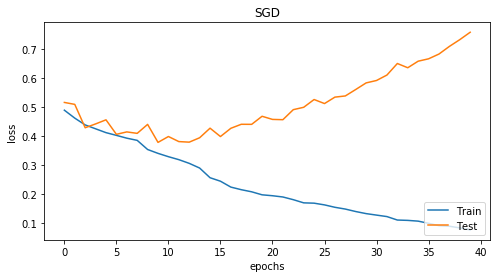

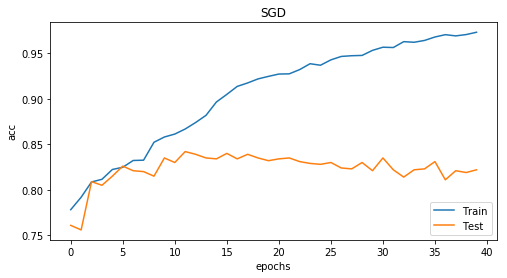

[0.761, 0.756, 0.809, 0.805, 0.815, 0.826, 0.821, 0.82, 0.815, 0.835, 0.83, 0.842, 0.839, 0.835, 0.834, 0.84, 0.834, 0.839, 0.835, 0.832, 0.834, 0.835, 0.831, 0.829, 0.828, 0.83, 0.824, 0.823, 0.83, 0.821, 0.835, 0.822, 0.814, 0.822, 0.823, 0.831, 0.811, 0.821, 0.819, 0.822]


In [31]:
    x=np.linspace(1, 40, 40)
    plt.figure(figsize=(8,4))
    #plt.plot(x,history.history['val_acc'],label="$accu$",color="red",linewidth=2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("SGD")
    #plt.ylim(-1.2,1.2)
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.show()
    
    
    xx=np.linspace(1, 40, 40)
    plt.figure(figsize=(8,4))
    #plt.plot(x,history.history['val_acc'],label="$accu$",color="red",linewidth=2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.title("SGD")
    #plt.ylim(-1.2,1.2)
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.show()
    print(history.history['val_acc'])

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

In [ ]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [ ]:
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

In [ ]:
predictions.shape

In [ ]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

In [ ]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

In [ ]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_tumor_tissue']

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

In [ ]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [ ]:
test_labels.shape

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
# Print the label associated with each class
test_gen.class_indices

In [ ]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['no_tumor_tissue', 'has_tumor_tissue']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)

In [ ]:
# Delete base_dir and it's sub folders to free up disk space.

shutil.rmtree('base_dir')

In [ ]:
#[CREATE A TEST FOLDER DIRECTORY STRUCTURE]

# We will be feeding test images from a folder into predict_generator().
# Keras requires that the path should point to a folder containing images and not
# to the images themselves. That is why we are creating a folder (test_images) 
# inside another folder (test_dir).

# test_dir
    # test_images

# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

In [ ]:
os.listdir('test_dir')

In [ ]:
# Transfer the test images into image_dir

test_list = os.listdir('../input/test')

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join('../input/test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    imagearray = readCroppedImage(src)
    r,g,b = cv2.split((imagearray * 255).astype(int)) 
    bgr_img = cv2.merge([b,g,r])
    cv2.imwrite(dst, bgr_img)
    

In [ ]:
# check that the images are now in the test_images
# Should now be 57458 images in the test_images folder

len(os.listdir('test_dir/test_images'))

In [ ]:
test_path ='test_dir'


# Here we change the path to point to the test_images folder.

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

In [ ]:
num_test_images = 57458

# make sure we are using the best epoch
model.load_weights('model.h5')

predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)

In [ ]:
# Are the number of predictions correct?
# Should be 57458.

len(predictions)

In [ ]:
# Put the predictions into a dataframe

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

In [ ]:
# This outputs the file names in the sequence in which 
# the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head()

In [ ]:
# Create an id column

# A file name now has this format: 
# test_images/00006537328c33e284c973d7b39d340809f7271b.tif

# This function will extract the id:
# 00006537328c33e284c973d7b39d340809f7271b


def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()

In [ ]:
# Get the predicted labels.
# We were asked to predict a probability that the image has tumor tissue
y_pred = df_preds['has_tumor_tissue']

# get the id column
image_id = df_preds['id']

In [ ]:
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

submission.to_csv('patch_preds.csv', columns=['label'])

In [ ]:
# Delete the test_dir directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

shutil.rmtree('test_dir')